In [1]:
import ray
import ray.rllib.agents.ppo as ppo
from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.policy.policy import Policy

import gymnasium as gym
import numpy as np
import random
import pandas as pd
import json
import os
import shutil
import sys
import matplotlib.pyplot as plt
import pprint
import glob
import random

from controle_temperatura_saida import simulacao_malha_temperatura
from controle_temperatura_saida import modelagem_sistema
from controle_temperatura_saida import modelo_valvula_saida
from controle_temperatura_saida import calculo_iqb
from controle_temperatura_saida import custo_eletrico_banho
from controle_temperatura_saida import custo_gas_banho
from controle_temperatura_saida import custo_agua_banho

seed = 33
random.seed(seed)
np.random.seed(seed)

In [22]:
class ShowerEnv(gym.Env):
    """Ambiente para simulação do modelo de chuveiro."""

    def __init__(self, env_config):

        # Define variáveis conforme o concept:
        self.Tinf = env_config["Tinf"]
        self.custo_eletrico_kwh = env_config["custo_eletrico_kwh"]
        self.selector = env_config["selector"]
        self.model = env_config["model"]

        # Tempo de simulação:
        self.dt = 0.01

        # Tempo de cada iteracao:
        self.tempo_iteracao = 2

        # Distúrbios e temperatura ambiente - Fd, Td, Tf, Tinf:
        self.Fd = 0
        self.Td = 25
        self.Tf = 25
        # self.Tinf = 25

        # Potência da resistência elétrica em kW:
        self.potencia_eletrica = 5.5

        # Potência do aquecedor boiler em kcal/h:
        self.potencia_aquecedor = 29000

        # Custo da energia elétrica em kWh, do kg do gás, e do m3 da água:
        # self.custo_eletrico_kwh = 2
        self.custo_gas_kg = 3
        self.custo_agua_m3 = 4

        # Fração da resistência elétrica:
        self.Sr = 0

        # Adiciona o número de concepts caso seja o selector:
        if self.selector == True:
            self.action_space = gym.spaces.Discrete(2)
            self.models = []

            for i in self.model:
                self.models.append(Policy.from_checkpoint(glob.glob(i+"/*")[-1])['default_policy'])
                #self.models.append(Algorithm.from_checkpoint(glob.glob(i+"/*")[-1]))

            self.model = self.models
            #print(self.model)

        else:
            # Ações - SPTs, SPTq, xs, Sr:
            self.action_space = gym.spaces.Tuple(
                (
                    gym.spaces.Box(low=30, high=40, shape=(1,), dtype=np.float32),
                    gym.spaces.Box(low=30, high=70, shape=(1,), dtype=np.float32),
                    gym.spaces.Box(low=0.1, high=0.99, shape=(1,), dtype=np.float32),
                    gym.spaces.Discrete(2, start=0),
                ),
            )
            # self.action_space = gym.spaces.Box(low=np.array([30, 30, 0.1, 0]), high=np.array([40, 70, 0.99, 1]), dtype=np.float32)

        # Estados - Ts, Tq, Tt, h, Fs, xq, xf, iqb, custo_eletrico, custo_gas, custo_agua:
        self.observation_space = gym.spaces.Box(
            low=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
            high=np.array([100, 100, 100, 10000, 100, 1, 1, 1, 2, 2, 2]),
            dtype=np.float32, 
        )

    def reset(self):

        # Random seed:
        super().reset(seed=seed)

        # Variáveis do concept:
        Tinf = self.Tinf
        custo_eletrico_kwh = self.custo_eletrico_kwh
        self.Tinf = Tinf
        self.custo_eletrico_kwh = custo_eletrico_kwh

        # Tempo inicial:
        self.tempo_inicial = 0

        # Nível do tanque de aquecimento e setpoint:
        self.h = 80
        self.SPh = 80

        # Temperatura de saída:
        self.Ts = self.Tinf

        # Temperatura do boiler:
        self.Tq = 55

        # Temperatura do tanque:
        self.Tt = self.Tinf

        # Vazão de saída:
        self.Fs = 0

        # Abertura da válvula quente:
        self.xq = 0

        # Abertura da válvula fria:
        self.xf = 0

        # Índice de qualidade do banho:
        self.iqb = 0

        # Custo elétrico do banho:
        self.custo_eletrico = 0

        # Custo do gás do banho:
        self.custo_gas = 0

        # Custo da água do banho:
        self.custo_agua = 0

        # Condições iniciais - Tq, h, Tt, Ts:
        self.Y0 = np.array([self.Tq, self.h] + 50 * [self.Tinf])

        # Define o buffer para os ganhos integral e derivativo das malhas de controle:
        # 0 - malha boiler, 1 - malha nível, 2 - malha tanque, 3 - malha saída
        id = [0, 1, 2, -1]
        self.Kp = np.array([1, 0.3, 2.0, 0.51])
        self.b = np.array([1, 1, 1, 0.8])
        self.I_buffer = self.Kp * self.Y0[id] * (1 - self.b)
        self.D_buffer = np.array([0, 0, 0, 0])  

        # Estados - Ts, Tq, Tt, h, Fs, xq, xf, iqb, custo_eletrico, custo_gas, custo_agua:
        self.obs = np.array([self.Ts, self.Tq, self.Tt, self.h, self.Fs, self.xq, self.xf, self.iqb,
                             self.custo_eletrico, self.custo_gas, self.custo_agua],
                             dtype=np.float32)
        
        return self.obs

    def step(self, action):

        # Tempo de cada iteração:
        self.tempo_final = self.tempo_inicial + self.tempo_iteracao

        # Seleciona a ação:
        if self.selector == True:
            actions = self.model[action].compute_single_action(self.obs, explore = False)[0] #
            #print(actions)

            # Setpoint da temperatura de saída:
            self.SPTs = round( (actions[0][0] * np.std([30,40])) + np.mean([30,40]), 1)
            # self.SPTs = round(actions[0], 1)

            # Setpoint da temperatura do boiler:
            self.SPTq = round((actions[1][0] * np.std([30,70])) + np.mean([30,70]) , 1)
            # self.SPTq = round(actions[1], 1)

            # Abertura da válvula de saída:
            self.xs = round((actions[2][0] * np.std([0.1,0.99])) + np.mean([0.1,0.99]), 2)
            # self.xs = round(actions[2], 2)

            # Split-range:
            self.split_range = actions[3]
            # self.split_range = round(actions[3])
            
            #print(self.SPTs, self.SPTq, self.xs, self.split_range)

        else:
            # Setpoint da temperatura de saída:
            self.SPTs = round(action[0][0], 1)
            # self.SPTs = round(action[0], 1)

            # Setpoint da temperatura do boiler:
            self.SPTq = round(action[1][0], 1)
            # self.SPTq = round(action[1], 1)

            # Abertura da válvula de saída:
            self.xs = round(action[2][0], 2)
            # self.xs = round(action[2], 2)

            # Split-range:
            self.split_range = action[3]
            # self.split_range = round(action[3])

        # Variáveis para simulação - tempo, SPTq, SPh, xq, xs, Tf, Td, Tinf, Fd, Sr:
        self.UT = np.array(
            [   
                [self.tempo_inicial, self.SPTq, self.SPh, self.SPTs, self.xs, self.Tf, self.Td, self.Tinf, self.Fd, self.Sr],
                [self.tempo_final, self.SPTq, self.SPh, self.SPTs, self.xs, self.Tf, self.Td, self.Tinf, self.Fd, self.Sr]
            ]
        )

        # Solução do sistema:
        self.TT, self.YY, self.UU, self.Y0, self.I_buffer, self.D_buffer = simulacao_malha_temperatura(
            modelagem_sistema, 
            self.Y0, 
            self.UT, 
            self.dt, 
            self.I_buffer,
            self.D_buffer,
            self.Tinf,
            self.split_range
        )

        # Valor final da temperatura do boiler:
        self.Tq = self.YY[:,0][-1]

        # Valor final do nível do tanque:
        self.h = self.YY[:,1][-1]

        # Valor final da temperatura do tanque:
        self.Tt = self.YY[:,2][-1]

        # Valor final da temperatura de saída:
        self.Ts = self.YY[:,3][-1]

        # Fração do aquecedor do boiler utilizada durante a iteração:
        self.Sa_total =  self.UU[:,0]

        # Fração da resistência elétrica utilizada durante a iteração:
        self.Sr_total = self.UU[:,8]

        # Valor final da abertura de corrente fria:
        self.xf = self.UU[:,1][-1]

        # Valor final da abertura de corrente quente:
        self.xq = self.UU[:,2][-1]

        # Valor final da abertura da válvula de saída:
        self.xs = self.UU[:,3][-1]

        # Valor final da vazão de saída:
        self.Fs = modelo_valvula_saida(self.xs)

        # Cálculo do índice de qualidade do banho:
        self.iqb = calculo_iqb(self.Ts, self.Fs)

        # Cálculo do custo elétrico do banho:
        self.custo_eletrico = custo_eletrico_banho(self.Sr_total, self.potencia_eletrica, self.custo_eletrico_kwh, self.dt)

        # Cálculo do custo de gás do banho:
        self.custo_gas = custo_gas_banho(self.Sa_total, self.potencia_aquecedor, self.custo_gas_kg, self.dt)

        # Cálculo do custo da água:
        self.custo_agua = custo_agua_banho(self.Fs, self.custo_agua_m3, self.tempo_iteracao)

        # Estados - Ts, Tq, Tt, h, Fs, xq, xf, iqb, custo_eletrico, custo_gas, custo_agua:
        self.obs = np.array([self.Ts, self.Tq, self.Tt, self.h, self.Fs, self.xq, self.xf, self.iqb,
                             self.custo_eletrico, self.custo_gas, self.custo_agua],
                             dtype=np.float32)

        # Define a recompensa:
        reward = 5 * self.iqb - self.custo_eletrico - self.custo_agua - self.custo_gas
        
        # Incrementa tempo inicial:
        self.tempo_inicial = self.tempo_inicial + self.tempo_iteracao

        # Termina o episódio se o tempo for maior que 14 ou se o nível do tanque ultrapassar 100:
        done = False
        if self.tempo_final == 14 or self.h > 100: 
            done = True

        info = {}

        return self.obs, reward, done, info
    
    def render(self):
        pass


In [23]:
def train_shower_model(concept, selector=False, model=None):

    path_root_models = "/models/"
    path_root = os.getcwd() + path_root_models
    path = path_root + "shower_model_" + concept
    print(path)

    # Seleciona as configurações do ambiente conforme o concept:
    if concept == "banho_dia_Tinf25":
        Tinf=25
        custo_eletrico_kwh = 1
    if concept == "banho_noite_Tinf25":
        Tinf=25
        custo_eletrico_kwh = 2
    if concept == "seleciona_banho":
        Tinf=25
        custo_eletrico_kwh = random.choice([1, 2])

    # Define as configurações para o algoritmo PPO e constrói o agente:
    agent = ppo.PPOTrainer(env=ShowerEnv, config={"env_config": {"Tinf": Tinf, "custo_eletrico_kwh": custo_eletrico_kwh, "selector": selector, "model": model}})

    # Armazena resultados:
    results = []
    episode_data = []

    # Realiza o treinamento:
    n_iter = 2
    for n in range(1, n_iter):

        # Treina o agente:
        result = agent.train()
        results.append(result)
        
        # Armazena dados do episódio:
        episode = {
            "n": n,
            "episode_reward_min": result["episode_reward_min"],
            "episode_reward_mean": result["episode_reward_mean"], 
            "episode_reward_max": result["episode_reward_max"],  
            "episode_len_mean": result["episode_len_mean"],
        }
        episode_data.append(episode)
        #print(result)

        # Salva checkpoint a cada 5 iterações:
        if n % 1 == 0:
            file_name = agent.save(path)
            print(f'{n:3d}: Min/Mean/Max reward: {result["episode_reward_min"]:8.4f}/{result["episode_reward_mean"]:8.4f}/{result["episode_reward_max"]:8.4f}. Checkpoint saved to {file_name}.')
        else:
            print(f'{n:3d}: Min/Mean/Max reward: {result["episode_reward_min"]:8.4f}/{result["episode_reward_mean"]:8.4f}/{result["episode_reward_max"]:8.4f}.')
  
    df = pd.DataFrame(data=episode_data)
    df.to_csv("episode_data_multiagent_ppo_v0_concept_" + concept + ".csv")

    return path

In [24]:
# Inicializa o Ray:
ray.shutdown()
ray.init()



2023-04-16 12:07:59,649	INFO worker.py:1550 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.7.4
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


In [5]:
# Treina cada concept:
banho_dia_Tinf25 = train_shower_model("banho_dia_Tinf25")


2023-04-15 18:53:08,046	WARNING deprecation.py:51 -- DeprecationWarning: `algo = Algorithm(env='<class '__main__.ShowerEnv'>', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('<class '__main__.ShowerEnv'>').build()` instead. This will raise an error in the future!
2023-04-15 18:53:08,048	INFO algorithm_config.py:2900 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-04-15 18:53:08,141	INFO algorithm.py:507 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


G:\Projetos Python\DRL Bonsai\RLLib\tcc-models-rllib/models/shower_model_banho_dia_Tinf25


(RolloutWorker pid=37876) c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\gymnasium\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=37876)   logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=37224) c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\gymnasium\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=37224)   logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=37224) 2023-04-15 18:53:16,201	WARNING utils.py:166 -- `config.auto_wrap_old_gym_envs` is activated AND you seem to have provided an old gym-API environment. RLlib will therefore try to auto-fix the following error. However, please consider switching over to the new `gymnasium` APIs:
(RolloutWorker pid=37224) Your environment ({}) does not abide to the new gymnasium-style API!
(Rollou

W0415 18:53:19.492241 30160 deprecation.py:323] From c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2023-04-15 18:53:20,686	INFO trainable.py:176 -- Trainable.setup took 12.547 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-04-15 18:53:20,688	WARNING util.py:67 -- Install gputil for GPU system monitoring.


  1: Min/Mean/Max reward:  -0.7363/  1.8562/ 16.0898. Checkpoint saved to G:\Projetos Python\DRL Bonsai\RLLib\tcc-models-rllib/models/shower_model_banho_dia_Tinf25\checkpoint_000001.


In [6]:
banho_noite_Tinf25 = train_shower_model("banho_noite_Tinf25")


2023-04-15 18:59:26,901	WARNING deprecation.py:51 -- DeprecationWarning: `algo = Algorithm(env='<class '__main__.ShowerEnv'>', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('<class '__main__.ShowerEnv'>').build()` instead. This will raise an error in the future!


G:\Projetos Python\DRL Bonsai\RLLib\tcc-models-rllib/models/shower_model_banho_noite_Tinf25


(RolloutWorker pid=17816) c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\gymnasium\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=17816)   logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=39820) c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\gymnasium\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=39820)   logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=39820) 2023-04-15 18:59:33,795	WARNING utils.py:166 -- `config.auto_wrap_old_gym_envs` is activated AND you seem to have provided an old gym-API environment. RLlib will therefore try to auto-fix the following error. However, please consider switching over to the new `gymnasium` APIs:
(RolloutWorker pid=39820) Your environment ({}) does not abide to the new gymnasium-style API!
(Rollou

  1: Min/Mean/Max reward:  -1.1182/  1.6616/ 16.0533. Checkpoint saved to G:\Projetos Python\DRL Bonsai\RLLib\tcc-models-rllib/models/shower_model_banho_noite_Tinf25\checkpoint_000001.


In [25]:
banho_dia_Tinf25 = '.\models\shower_model_banho_dia_Tinf25'
banho_noite_Tinf25 = '.\models\shower_model_banho_noite_Tinf25'

In [26]:
# Treina o seletor:
selector_path = train_shower_model("seleciona_banho", True, [banho_dia_Tinf25, banho_noite_Tinf25])

# Reseta o Ray:
#ray.shutdown()

2023-04-16 12:08:02,230	WARNING deprecation.py:51 -- DeprecationWarning: `algo = Algorithm(env='<class '__main__.ShowerEnv'>', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('<class '__main__.ShowerEnv'>').build()` instead. This will raise an error in the future!


G:\Projetos Python\DRL Bonsai\RLLib\tcc-models-rllib/models/shower_model_seleciona_banho


(RolloutWorker pid=5912) WARNING: Logging before flag parsing goes to stderr.
(RolloutWorker pid=5912) W0416 12:08:11.827006 14816 deprecation.py:506] From c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(RolloutWorker pid=5912) Instructions for updating:
(RolloutWorker pid=5912) If using Keras pass *_constraint arguments to layers.
(RolloutWorker pid=38092) WARNING: Logging before flag parsing goes to stderr.
(RolloutWorker pid=38092) W0416 12:08:11.827006 37824 deprecation.py:506] From c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be 

  1: Min/Mean/Max reward:   9.7959/ 10.0148/ 10.2419. Checkpoint saved to G:\Projetos Python\DRL Bonsai\RLLib\tcc-models-rllib/models/shower_model_seleciona_banho\checkpoint_000001.


In [33]:
selector_path = '.\models\shower_model_seleciona_banho'

In [ ]:
#Benchmark

In [50]:
#Benchmark

concept = "banho_noite_Tinf25"
selector = True
model = [banho_dia_Tinf25, banho_noite_Tinf25]

# Seleciona as configurações do ambiente conforme o concept:
if concept == "banho_dia_Tinf25":
    Tinf=25
    custo_eletrico_kwh = 1
if concept == "banho_noite_Tinf25":
    Tinf=25
    custo_eletrico_kwh = 2
if concept == "seleciona_banho":
    Tinf=25
    custo_eletrico_kwh = random.choice([1, 2])

#bench_env = CSTREnv({"Cref_signal":4,"selector": True, "model":[trans_model, ss1_model, ss2_model]})
bench_env = ShowerEnv({"Tinf": Tinf, "custo_eletrico_kwh": custo_eletrico_kwh, "selector": selector, "model": model})

obs = bench_env.reset()

c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\gymnasium\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [53]:
model = Algorithm.from_checkpoint(glob.glob(selector_path +"/*")[-1])
#G:\Projetos Python\DRL Bonsai\RLLib\tcc-models-rllib/models/shower_model_banho_noite_Tinf25

(RolloutWorker pid=20944) WARNING: Logging before flag parsing goes to stderr.
(RolloutWorker pid=20944) W0416 12:20:36.317289 34244 deprecation.py:506] From c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(RolloutWorker pid=20944) Instructions for updating:
(RolloutWorker pid=20944) If using Keras pass *_constraint arguments to layers.
(RolloutWorker pid=33536) WARNING: Logging before flag parsing goes to stderr.
(RolloutWorker pid=33536) W0416 12:20:36.317289  7368 deprecation.py:506] From c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will

In [54]:
df = pd.DataFrame()

In [55]:
for n in range(10):
    action = model.compute_single_action(obs)
    obs, reward, done, info = bench_env.step(action)
    df = df.append( pd.DataFrame(columns=['Ts', 'Tq', 'Tt','h', 'Fs', 'xq', 'xf', 'iqb',
                             'custo_eletrico', 'custo_gas', 'custo_agua'], data=[obs]))
    #print(reward)
    print(action)
    print(obs)

0
[3.3146553e+01 5.1091892e+01 3.6053310e+01 8.0019989e+01 9.2541828e+00
 1.0000000e+00 1.5631163e-01 6.8191603e-02 3.5765570e-01 1.9436170e-01
 7.4033462e-02]
1
[3.5754555e+01 5.2064732e+01 3.6564049e+01 7.9800636e+01 8.3200731e+00
 3.2701826e-01 4.9073586e-01 3.5323355e-01 1.4174100e-02 1.0119149e-01
 6.6560589e-02]
1
[3.5885437e+01 5.2238941e+01 3.6571968e+01 7.9996933e+01 7.9373250e+00
 3.4703982e-01 4.4605395e-01 3.7700519e-01 0.0000000e+00 9.1319151e-02
 6.3498601e-02]
0
[3.5879875e+01 5.0804157e+01 3.6680614e+01 8.0018135e+01 6.8360038e+00
 3.1335571e-01 3.6936700e-01 3.7235641e-01 0.0000000e+00 8.0829784e-02
 5.4688029e-02]
1
[3.5912258e+01 5.3500568e+01 3.6621418e+01 7.9980560e+01 7.7328305e+00
 3.3545616e-01 4.3800408e-01 3.8249269e-01 0.0000000e+00 8.9468084e-02
 6.1862644e-02]
0
[3.5890110e+01 5.0123257e+01 3.6716217e+01 8.0018837e+01 6.5949821e+00
 3.0448478e-01 3.5402274e-01 3.7412184e-01 0.0000000e+00 7.6510638e-02
 5.2759856e-02]
1
[3.5920918e+01 5.1424484e+01 3.6626087

In [56]:
df

,Ts,Tq,Tt,h,Fs,xq,xf,iqb,custo_eletrico,custo_gas,custo_agua
0,33.146553,51.091892,36.053310,80.019989,9.254183,1.000000,0.156312,0.068192,0.357656,0.194362,0.074033
0,35.754555,52.064732,36.564049,79.800636,8.320073,0.327018,0.490736,0.353234,0.014174,0.101191,0.066561
0,35.885437,52.238941,36.571968,79.996933,7.937325,0.347040,0.446054,0.377005,0.000000,0.091319,0.063499
0,35.879875,50.804157,36.680614,80.018135,6.836004,0.313356,0.369367,0.372356,0.000000,0.080830,0.054688
0,35.912258,53.500568,36.621418,79.980560,7.732831,0.335456,0.438004,0.382493,0.000000,0.089468,0.061863
0,35.890110,50.123257,36.716217,80.018837,6.594982,0.304485,0.354023,0.374122,0.000000,0.076511,0.052760
0,35.920918,51.424484,36.626087,79.969193,7.732831,0.334564,0.442278,0.384388,0.000000,0.087617,0.061863
0,35.911037,52.110661,36.600517,79.997551,7.937325,0.346238,0.448218,0.382300,0.000000,0.091319,0.063499
0,35.888100,52.945007,36.689568,80.024071,6.836004,0.314012,0.368332,0.374581,0.000000,0.082064,0.054688
0,35.908989,51.552147,36.640720,79.981674,7.519976,0.327672,0.424585,0.381582,0.000000,0.085766,0.060160


In [58]:
df = df.reset_index()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

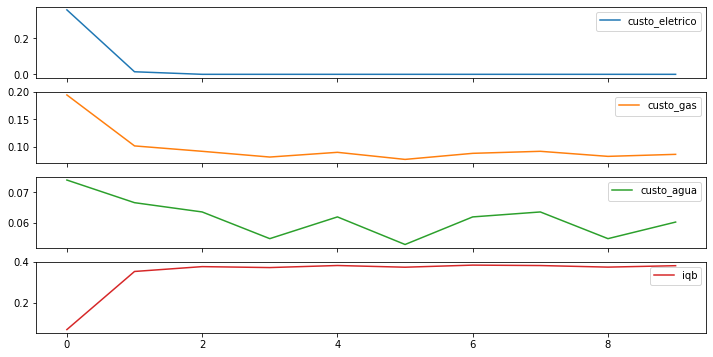

In [65]:
#plt.figure(figsize=(12, 6))
df[['custo_eletrico','custo_gas','custo_agua','iqb']].plot(figsize=(12, 6), subplots = True)

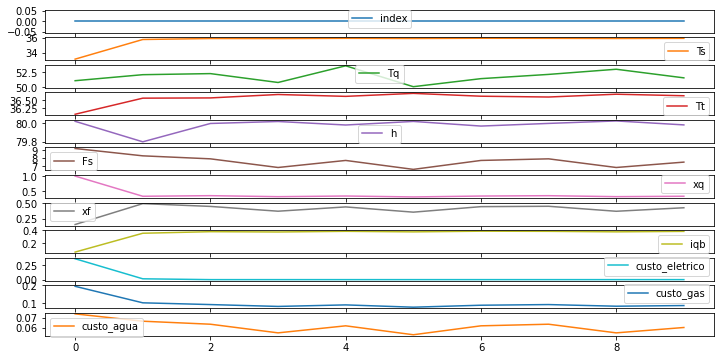

In [63]:
#plt.figure(figsize=(12, 6))
df.plot(figsize=(12, 6),subplots = True)
plt.show()

# debug

In [37]:
#glob.glob(banho_noite_Tinf25+"/*")

In [38]:
#glob.glob('G:\Projetos Python\DRL Bonsai\RLLib\tcc-models-rllib\models\shower_model_banho_dia_Tinf25\*')

In [29]:
glob.glob('.\models\shower_model_banho_dia_Tinf25\*')

['.\\models\\shower_model_banho_dia_Tinf25\\checkpoint_000001']

In [39]:
Policy.from_checkpoint(glob.glob(banho_noite_Tinf25+"/*")[-1])['default_policy'].compute_single_action(obs,explore =False)

((array([0.06755488], dtype=float32),
  array([0.06826273], dtype=float32),
  array([0.29896575], dtype=float32),
  1),
 [],
 {'action_prob': 1.0,
  'action_logp': 0.0,
  'action_dist_inputs': array([ 0.06755488, -0.02742026,  0.06826273, -0.0412504 ,  0.29896575,
         -0.15659359, -0.03392194,  0.03141291], dtype=float32),
  'vf_preds': 0.2988099})

In [81]:
model.compute_single_action(obs, explore =False)

(array([35.24449], dtype=float32),
 array([51.241062], dtype=float32),
 array([0.6751003], dtype=float32),
 1)

In [40]:
pol = Policy.from_checkpoint(glob.glob(banho_noite_Tinf25+"/*")[-1])

In [58]:
pol['default_policy'].compute_single_action(obs, explore = False)

((array([0.06755488], dtype=float32),
  array([0.06826273], dtype=float32),
  array([0.29896575], dtype=float32),
  1),
 [],
 {'action_prob': 1.0,
  'action_logp': 0.0,
  'action_dist_inputs': array([ 0.06755488, -0.02742026,  0.06826273, -0.0412504 ,  0.29896575,
         -0.15659359, -0.03392194,  0.03141291], dtype=float32),
  'vf_preds': 0.2988099})

In [105]:
pol['default_policy'].get_state()

{'weights': OrderedDict([('var_scope_3/fc_1/kernel',
               array([[ 0.5320656 , -0.08544712,  0.10546441, ...,  0.08841079,
                        0.10647608,  0.13707072],
                      [-0.18709268,  0.03822591, -0.1240128 , ..., -0.20233206,
                       -0.3851608 ,  0.33177218],
                      [-0.31862715, -0.05184793,  0.48261622, ..., -0.60854846,
                        0.10653677, -0.43839735],
                      ...,
                      [ 0.5936621 ,  0.07364623,  0.21723117, ...,  0.10406475,
                       -0.10531961,  0.04751804],
                      [-0.10675322, -0.5009134 ,  0.08571598, ..., -0.3399502 ,
                        0.16366968,  0.17793274],
                      [-0.06594846, -0.05184536,  0.4277213 , ...,  0.21499267,
                        0.2720503 ,  0.17300491]], dtype=float32)),
              ('var_scope_3/fc_1/bias',
               array([ 1.5360328e-03, -4.5648320e-03, -3.2923106e-04,  1.5292223e-

In [97]:
a.compute_single_action(obs, explore =False)

((array([0.04889807], dtype=float32),
  array([0.0620531], dtype=float32),
  array([0.29236016], dtype=float32),
  1),
 [],
 {'action_prob': 1.0,
  'action_logp': 0.0,
  'action_dist_inputs': array([ 0.04889807, -0.00795238,  0.0620531 , -0.04829327,  0.29236016,
         -0.14959346, -0.03116588,  0.02731905], dtype=float32),
  'vf_preds': 0.26401836})

In [135]:
model.get_weights()

{'default_policy': OrderedDict([('default_policy/fc_1/kernel',
               array([[ 0.5320656 , -0.08544712,  0.10546441, ...,  0.08841079,
                        0.10647608,  0.13707072],
                      [-0.18709268,  0.03822591, -0.1240128 , ..., -0.20233206,
                       -0.3851608 ,  0.33177218],
                      [-0.31862715, -0.05184793,  0.48261622, ..., -0.60854846,
                        0.10653677, -0.43839735],
                      ...,
                      [ 0.5936621 ,  0.07364623,  0.21723117, ...,  0.10406475,
                       -0.10531961,  0.04751804],
                      [-0.10675322, -0.5009134 ,  0.08571598, ..., -0.3399502 ,
                        0.16366968,  0.17793274],
                      [-0.06594846, -0.05184536,  0.4277213 , ...,  0.21499267,
                        0.2720503 ,  0.17300491]], dtype=float32)),
              ('default_policy/fc_1/bias',
               array([ 1.5360328e-03, -4.5648320e-03, -3.2923106e-04,

In [138]:
model.get_policy().config #'actions_in_input_normalized' 'normalize_actions'

{'extra_python_environs_for_driver': {},
 'extra_python_environs_for_worker': {},
 'num_gpus': 0,
 'num_cpus_per_worker': 1,
 'num_gpus_per_worker': 0,
 '_fake_gpus': False,
 'num_trainer_workers': 0,
 'num_gpus_per_trainer_worker': 0,
 'num_cpus_per_trainer_worker': 1,
 'custom_resources_per_worker': {},
 'placement_strategy': 'PACK',
 'eager_tracing': False,
 'eager_max_retraces': 20,
 'tf_session_args': {'intra_op_parallelism_threads': 8,
  'inter_op_parallelism_threads': 8,
  'gpu_options': {'allow_growth': True},
  'log_device_placement': False,
  'device_count': {'CPU': 1},
  'allow_soft_placement': True},
 'local_tf_session_args': {'intra_op_parallelism_threads': 8,
  'inter_op_parallelism_threads': 8},
 'env': __main__.ShowerEnv,
 'env_config': {'Tinf': 25,
  'custo_eletrico_kwh': 2,
  'selector': False,
  'model': None},
 'observation_space': None,
 'action_space': None,
 'env_task_fn': None,
 'render_env': False,
 'clip_rewards': None,
 'normalize_actions': True,
 'clip_actio

In [164]:
model.get_policy().

'tf'

In [151]:
model.config.normalize_actions

In [168]:
model.compute_single_action(obs, explore =False, unsquash_action=False) #errado
model.compute_single_action(obs, explore =False, unsquash_action=True) #certo

(array([35.337776], dtype=float32),
 array([51.365253], dtype=float32),
 array([0.6780397], dtype=float32),
 1)

In [152]:
#model.setup(config={'normalize_actions':False})

(RolloutWorker pid=16748) 2023-04-15 23:00:29,244	ERROR worker.py:772 -- Exception raised in creation task: The actor died because of an error raised in its creation task, ray::RolloutWorker.__init__() (pid=16748, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x00000288773C8D08>)
(RolloutWorker pid=16748)   File "python\ray\_raylet.pyx", line 857, in ray._raylet.execute_task
(RolloutWorker pid=16748)   File "python\ray\_raylet.pyx", line 861, in ray._raylet.execute_task
(RolloutWorker pid=16748)   File "python\ray\_raylet.pyx", line 803, in ray._raylet.execute_task.function_executor
(RolloutWorker pid=16748)   File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
(RolloutWorker pid=16748)     return method(__ray_actor, *args, **kwargs)
(RolloutWorker pid=16748)   File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\util\tracing

KeyError: 'Tinf'

In [133]:
model.get_policy().compute_single_action(obs, explore =False)

((array([0.06755488], dtype=float32),
  array([0.06826273], dtype=float32),
  array([0.29896575], dtype=float32),
  1),
 [],
 {'action_prob': 1.0,
  'action_logp': 0.0,
  'action_dist_inputs': array([ 0.06755488, -0.02742026,  0.06826273, -0.0412504 ,  0.29896575,
         -0.15659359, -0.03392194,  0.03141291], dtype=float32),
  'vf_preds': 0.2988099})

In [90]:
model.workers.foreach_worker(lambda x: x.get_policy().compute_single_action(obs, explore =False, full_fetch=True))

[((array([0.06755488], dtype=float32),
   array([0.06826273], dtype=float32),
   array([0.29896575], dtype=float32),
   1),
  [],
  {'action_prob': 1.0,
   'action_logp': 0.0,
   'action_dist_inputs': array([ 0.06755488, -0.02742026,  0.06826273, -0.0412504 ,  0.29896575,
          -0.15659359, -0.03392194,  0.03141291], dtype=float32),
   'vf_preds': 0.2988099}),
 ((array([0.06755488], dtype=float32),
   array([0.06826273], dtype=float32),
   array([0.29896575], dtype=float32),
   1),
  [],
  {'action_prob': 1.0,
   'action_logp': 0.0,
   'action_dist_inputs': array([ 0.06755488, -0.02742026,  0.06826273, -0.0412504 ,  0.29896575,
          -0.15659359, -0.03392194,  0.03141291], dtype=float32),
   'vf_preds': 0.2988099}),
 ((array([0.06755488], dtype=float32),
   array([0.06826273], dtype=float32),
   array([0.29896575], dtype=float32),
   1),
  [],
  {'action_prob': 1.0,
   'action_logp': 0.0,
   'action_dist_inputs': array([ 0.06755488, -0.02742026,  0.06826273, -0.0412504 ,  0.298

In [185]:
model.workers.local_worker().policy_config.update(normalize_actions= False)

In [197]:
#model.workers.local_worker().policy_config.update(action_space=True) #.get_policy().compute_single_action(obs, explore =False)

In [114]:
model.export_policy_model('/tmp/dir/')

In [117]:
Policy.import_model_from_h5('/tmp/dir/*')

TypeError: import_model_from_h5() missing 1 required positional argument: 'import_file'

In [120]:
pol['default_policy'].get_state()

{'weights': OrderedDict([('var_scope_3/fc_1/kernel',
               array([[ 0.5320656 , -0.08544712,  0.10546441, ...,  0.08841079,
                        0.10647608,  0.13707072],
                      [-0.18709268,  0.03822591, -0.1240128 , ..., -0.20233206,
                       -0.3851608 ,  0.33177218],
                      [-0.31862715, -0.05184793,  0.48261622, ..., -0.60854846,
                        0.10653677, -0.43839735],
                      ...,
                      [ 0.5936621 ,  0.07364623,  0.21723117, ...,  0.10406475,
                       -0.10531961,  0.04751804],
                      [-0.10675322, -0.5009134 ,  0.08571598, ..., -0.3399502 ,
                        0.16366968,  0.17793274],
                      [-0.06594846, -0.05184536,  0.4277213 , ...,  0.21499267,
                        0.2720503 ,  0.17300491]], dtype=float32)),
              ('var_scope_3/fc_1/bias',
               array([ 1.5360328e-03, -4.5648320e-03, -3.2923106e-04,  1.5292223e-

In [113]:
obs

array([2.6693619e+01, 3.0611837e+01, 2.7093380e+01, 7.9966927e+01,
       1.0923171e+01, 9.9000001e-01, 4.0545264e-01, 6.5281626e-04,
       0.0000000e+00, 4.3191489e-02, 8.7385371e-02], dtype=float32)

In [177]:
model.get_policy().action_space

Tuple(Box(30.0, 40.0, (1,), float32), Box(30.0, 70.0, (1,), float32), Box(0.1, 0.99, (1,), float32), Discrete(2))